In [1]:
!mkdir -p /scratch/sagarsj42/torch-cache
!mkdir -p /scratch/sagarsj42/transformers
!mkdir -p /scratch/sagarsj42/hf-datasets

import os
os.chdir('/scratch/sagarsj42')
os.environ['TORCH_HOME'] = '/scratch/sagarsj42/torch-cache'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/sagarsj42/hf-datasets'

In [2]:
import string

import datasets
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import transformers
from transformers import BertTokenizer, BertModel

2021-12-09 23:29:58.027630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-09 23:29:58.027669: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
# Copied from explore_wikiqa.ipynb
def get_valid_questions(wikiqa):
    question_status = dict()

    for split in wikiqa:
        split_dataset = wikiqa[split]
        n_samples = len(split_dataset)

        for i in range(n_samples):
            qid = split_dataset[i]['question_id']
            label = split_dataset[i]['label']
            if qid not in question_status:
                question_status[qid] = label
            else:
                question_status[qid] = max(question_status[qid], label)

    valid_questions = set([qid for qid in question_status if question_status[qid] > 0])
    
    return valid_questions

In [40]:
class WikiqaDataset(Dataset):
    def __init__(self, wikiqa, tokenizer, max_length):
        super(WikiqaDataset, self).__init__()
        self.wikiqa = wikiqa
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.wikiqa)
    
    def __getitem__(self, idx):
        sample = self.wikiqa[idx]
        question = sample['question'].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        sentence = sample['answer'].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        label = sample['label'] * 1.0
        
        input_enc = tokenizer(text=question, text_pair=sentence, 
                              add_special_tokens=True, truncation=True, padding='max_length', 
                              max_length=self.max_length, 
                              return_tensors='pt', return_attention_mask=True)
        
        return (input_enc['input_ids'].flatten(), input_enc['attention_mask'].flatten(), 
                input_enc['token_type_ids'].flatten(), label)

In [41]:
class BertQA(nn.Module):
    def __init__(self, encoder):
        super(BertQA, self).__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(768, 512),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(512, 1),
            nn.Dropout(p=0.15),
        )
        
    def forward(self, x):
        a = x[1]
        x = self.encoder(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2]).last_hidden_state
        x = (x * a.unsqueeze(-1) / a.sum(1).view(-1, 1, 1)).sum(1)
        x = self.layers(x)
        
        return x

In [7]:
wikiqa = datasets.load_dataset('wiki_qa')
valid_questions = get_valid_questions(wikiqa)
wikiqa_f = wikiqa.filter(lambda sample: sample['question_id'] in valid_questions)

wikiqa_f

Using the latest cached version of the module from /home2/sagarsj42/.cache/huggingface/modules/datasets_modules/datasets/wiki_qa/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c (last modified on Sat Nov 20 13:05:25 2021) since it couldn't be found locally at /scratch/sagarsj42/wiki_qa/wiki_qa.py, or remotely (ConnectionError).
Using custom data configuration default
Reusing dataset wiki_qa (/scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c)


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2351
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 1130
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 8672
    })
})

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoder = BertModel.from_pretrained('bert-base-uncased')
encoder.to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [42]:
model = BertQA(encoder)
model.to(DEVICE)

BertQA(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [43]:
tok_lengths = list()

for sample in wikiqa_f['train']:
    question = sample['question']
    sentence = sample['answer']
    tok_len = len(tokenizer(text=question, text_pair=sentence)['input_ids'])
    tok_lengths.append(tok_len)
    
len(tok_lengths)

8672

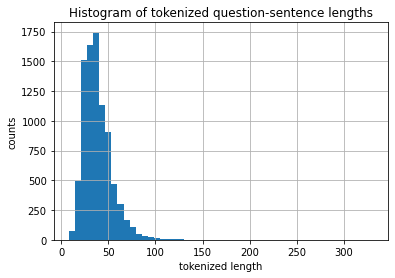

In [44]:
plt.hist(tok_lengths, density=False, bins=50)
plt.xlabel('tokenized length')
plt.ylabel('counts')
plt.title('Histogram of tokenized question-sentence lengths')
plt.grid()
plt.show()

In [45]:
batch_size = 32
n_epochs = 20
learning_rate = 5e-5
n_epochs = 4

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-7)

criterion = nn.BCEWithLogitsLoss()
criterion

BCEWithLogitsLoss()

In [46]:
train_dataset = WikiqaDataset(wikiqa_f['train'], tokenizer, max_length=64)
dev_dataset = WikiqaDataset(wikiqa_f['validation'], tokenizer, max_length=64)
test_dataset = WikiqaDataset(wikiqa_f['test'], tokenizer, max_length=64)

len(train_dataset), len(dev_dataset), len(test_dataset)

(8672, 1130, 2351)

In [47]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataloader), len(dev_dataloader), len(test_dataloader)

(271, 36, 74)

In [53]:
def train_epoch(dataloader, model, optimizer, criterion, device='cpu'):
    model.to(device)
    model.train()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = [s.to(device) for s in sample]
        optimizer.zero_grad()
        output = model(sample[:-1])
        loss = criterion(output.flatten(), sample[-1].flatten())
        loss.backward()
        total_loss += loss.item()
        
    return total_loss / n_batches

In [ ]:
train_epoch(train_dataloader, model, optimizer, criterion)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai